In [2]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [3]:
pip install geopy

    100% |████████████████████████████████| 102kB 2.6MB/s a 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
Note: you may need to restart the kernel to use updated packages.


In [4]:
from geopy.distance import geodesic

In [24]:
class Building:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, building):
        distance = geodesic((self.x, self.y), (building.x, building.y)).meters
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

In [26]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromBuilding = self.route[i]
                toBuilding = None
                if i + 1 < len(self.route):
                    toBuilding = self.route[i + 1]
                else:
                    toBuilding = self.route[0]
                pathDistance += fromBuilding.distance(toBuilding)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [27]:
def createRoute(buildingList):
    
    route = random.sample(buildingList[1::], len(buildingList)-1)
    route.insert(0, buildingList[0])
    return route

In [28]:
def initialPopulation(popSize, buildingList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(buildingList))
    return population

In [29]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    sortedFitness = sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)    
    print("Current Distance", str(1 / sortedFitness[0][1]))
    return sortedFitness

In [30]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [31]:

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [32]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [33]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [34]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            building1 = individual[swapped]
            building2 = individual[swapWith]
            
            individual[swapped] = building2
            individual[swapWith] = building1
    return individual

In [35]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    firstBuilding = Building(-36.853138, 174.769674)
    index = 0
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        
        for i in range(len(mutatedInd)):
            if mutatedInd[i] == firstBuilding:
                index = i
        
        del mutatedInd[index]
        mutatedInd.insert(0, firstBuilding)
        
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [36]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [37]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        print("Generation:", i)
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [38]:
buildingList = []

buildingList.append(Building(-36.853138, 174.769674)) #"Engineering"
buildingList.append(Building(-36.852597, 174.768177)) #"Science 303"
buildingList.append(Building(-36.853251, 174.771082)) #"OGGB"
buildingList.append(Building(-36.852160, 174.769584)) #"Kate Edgar"
buildingList.append(Building(-36.851760, 174.771774)) #"HSB"
buildingList.append(Building(-36.852577, 174.771755)) #"Fisher and Paykel"
buildingList.append(Building(-36.851061, 174.770647)) #"Biology"
buildingList.append(Building(-36.850845, 174.770209)) #"Elam B"
buildingList.append(Building(-36.851499, 174.770300)) #"Old Choral Hall"
buildingList.append(Building(-36.851193, 174.769165)) #"General Library"
buildingList.append(Building(-36.850286, 174.769455)) #"Clock Tower"
buildingList.append(Building(-36.850894, 174.771996)) #"Music school"
buildingList.append(Building(-36.851951, 174.771233)) #"Arts 1"
buildingList.append(Building(-36.852217, 174.770882)) #"Arts 2"
buildingList.append(Building(-36.851669, 174.768904)) #"AUSA house"
buildingList.append(Building(-36.850459, 174.770403)) #"Commerce A"
buildingList.append(Building(-36.853290, 174.768399)) #"Science 301"
buildingList.append(Building(-36.852244, 174.772155)) #"Fale Pasifika"

In [46]:
geneticAlgorithm(population=buildingList, popSize=100, eliteSize=20, mutationRate=0.01, generations=5)

Current Distance 2809.2360966535116
Initial distance: 2809.2360966535116
Generation: 0
Current Distance 2809.2360966535116
Generation: 1
Current Distance 2581.7900592655774
Generation: 2
Current Distance 2581.7900592655774
Generation: 3
Current Distance 2581.7900592655774
Generation: 4
Current Distance 2505.307227364605
Current Distance 2505.307227364605
Final distance: 2505.307227364605
Current Distance 2505.307227364605


[(-36.853138,174.769674),
 (-36.852597,174.768177),
 (-36.850894,174.771996),
 (-36.851061,174.770647),
 (-36.850459,174.770403),
 (-36.85176,174.771774),
 (-36.852217,174.770882),
 (-36.853251,174.771082),
 (-36.85329,174.768399),
 (-36.85216,174.769584),
 (-36.851669,174.768904),
 (-36.850286,174.769455),
 (-36.850845,174.770209),
 (-36.851193,174.769165),
 (-36.851499,174.7703),
 (-36.851951,174.771233),
 (-36.852244,174.772155),
 (-36.852577,174.771755)]

In [52]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if ()
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

    pop = initialPopulation(popSize, population)    
    for i in range(0, generations):
        print("Generation:", i)
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

Current Distance 2832.079241069676
Current Distance 2832.079241069676
Current Distance 2752.9990679088646
Current Distance 2752.9990679088646
Current Distance 2386.995300106265
Current Distance 2386.995300106265
Current Distance 2386.995300106265
Current Distance 2386.995300106265
Current Distance 2310.2758469571436
Current Distance 2310.2758469571436
Current Distance 2374.9802014099973
Current Distance 2374.9802014099973
Current Distance 2374.9802014099973
Current Distance 2374.9802014099973
Current Distance 2339.8002950055566
Current Distance 2339.8002950055566
Current Distance 2264.7485674208797
Current Distance 2264.7485674208797
Current Distance 2264.7485674208797
Current Distance 2264.7485674208797
Current Distance 2209.506311921679
Current Distance 2209.506311921679
Current Distance 2157.6922566294243
Current Distance 2157.6922566294243
Current Distance 2157.6922566294243
Current Distance 2157.6922566294243
Current Distance 2095.9739261210616
Current Distance 2095.9739261210616


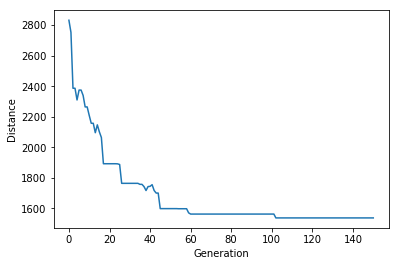

Current Distance 1538.2274438373274


[(-36.851061,174.770647),
 (-36.851499,174.7703),
 (-36.850845,174.770209),
 (-36.850459,174.770403),
 (-36.850286,174.769455),
 (-36.851193,174.769165),
 (-36.851669,174.768904),
 (-36.85216,174.769584),
 (-36.852597,174.768177),
 (-36.85329,174.768399),
 (-36.853138,174.769674),
 (-36.853251,174.771082),
 (-36.852577,174.771755),
 (-36.852244,174.772155),
 (-36.852217,174.770882),
 (-36.851951,174.771233),
 (-36.85176,174.771774),
 (-36.850894,174.771996)]

In [36]:
geneticAlgorithmPlot(population=buildingList, popSize=100, eliteSize=20, mutationRate=0.01, generations=300)

In [47]:
array1 = [[(-36.853138, 174.769674), "Engineering"],
         [(-36.852597, 174.768177), "Science 303"],
         [(-36.853251, 174.771082), "OGGB"],
         [(-36.852160, 174.769584), "Kate Edgar"],
         [(-36.851760, 174.771774), "HSB"],
        [(-36.852577, 174.771755), "Fisher and Paykel"],
            [(-36.851061, 174.770647), "Biology"],
            [(-36.850845, 174.770209), "Elam B"],
            [(-36.851499, 174.770300), "Old Choral Hall"],
            [(-36.851193, 174.769165), "General Library"],
            [(-36.850286, 174.769455), "Clock Tower"],
            [(-36.850894, 174.771996), "Music school"],
            [(-36.851951, 174.771233), "Arts 1"],
            [(-36.852217, 174.770882), "Arts 2"],
            [(-36.851669, 174.768904), "AUSA house"],
            [(-36.850459, 174.770403), "Commerce A"],
            [(-36.853290, 174.768399), "Science 301"],
            [(-36.852244, 174.772155), "Fale Pasifika"] ]

winner = [(-36.853138,174.769674),
 (-36.851061,174.770647),
 (-36.851193,174.769165),
 (-36.850286,174.769455),
 (-36.850459,174.770403),
 (-36.850894,174.771996),
 (-36.852244,174.772155),
 (-36.85176,174.771774),
 (-36.851951,174.771233),
 (-36.852577,174.771755),
 (-36.852597,174.768177),
 (-36.85329,174.768399),
 (-36.85216,174.769584),
 (-36.851669,174.768904),
 (-36.851499,174.7703),
 (-36.850845,174.770209),
 (-36.852217,174.770882),
 (-36.853251,174.771082)]
count = 0
for j in winner:
    for element in array1:
        if element[0] == j:
            print(element[1])
            count+=1

Engineering
Biology
General Library
Clock Tower
Commerce A
Music school
Fale Pasifika
HSB
Arts 1
Fisher and Paykel
Science 303
Science 301
Kate Edgar
AUSA house
Old Choral Hall
Elam B
Arts 2
OGGB
